In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:

class Value:
  """ stores a single scalar value and its gradient """
  def __init__(self, data, _children=(), _op='',label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self.label = label
    self._op = _op
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out
  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out
  def __neg__(self):
    return self * -1
  def __radd__(self, other):
    return self + other
  def __sub__(self, other):
    return self + (-other)
  def __rsub__(self, other):
    return other + (-self)
  def __rmul__(self, other):
    return self * other
  def __truediv__(self, other):
    return self * other**-1
  def __rtruediv__(self, other):
    return other * self**-1
  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"
  
  def tanh(self):
    x = self.data
    e_2x = math.exp(2*x)
    t = (e_2x - 1)/(e_2x + 1)
    out = Value(t, (self, ), 'tanh')
    return out

  def backward(self):  
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [4]:
x1 = Value(2,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.8813,label='b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +  b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'

o.backward()

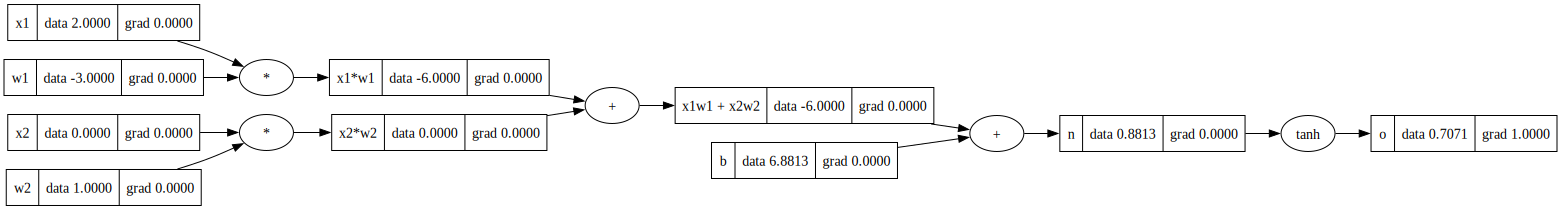

In [5]:
draw_dot(o)

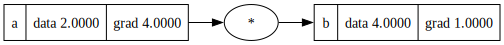

In [6]:
a = Value(2,label='a')
b = a*a ; b.label = 'b'
b.backward()
draw_dot(b)

In [7]:
print(a+4)
print(6+a)
print(2*a)
print(a*0.4)

Value(data=6, grad=0)
Value(data=8, grad=0)
Value(data=4, grad=0)
Value(data=0.8, grad=0)


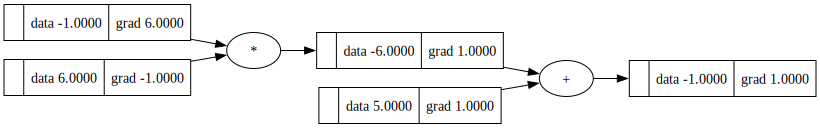

In [8]:
a = Value(5)
b = Value(6)
c = a-b
c.backward()
draw_dot(c)

In [9]:
"""
Creating neurons
nin - num of inputs
w   - weight
b   - bias
"""
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

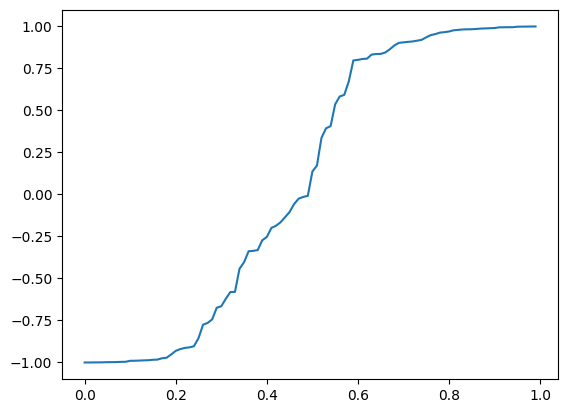

In [10]:
x = [2.0,3.0]
n = Layer(3,100)

y = sorted([p.data for p in n(x)])
# print(y)

plt.plot(np.arange(0,1,0.01),y)

In [11]:
"""
3 x 4 x 4 x 1
"""
inp = [1.0,2.0,3.0]
N = MLP(3,[4,4,1])
N(inp)

Value(data=-0.9595023644125373, grad=0)

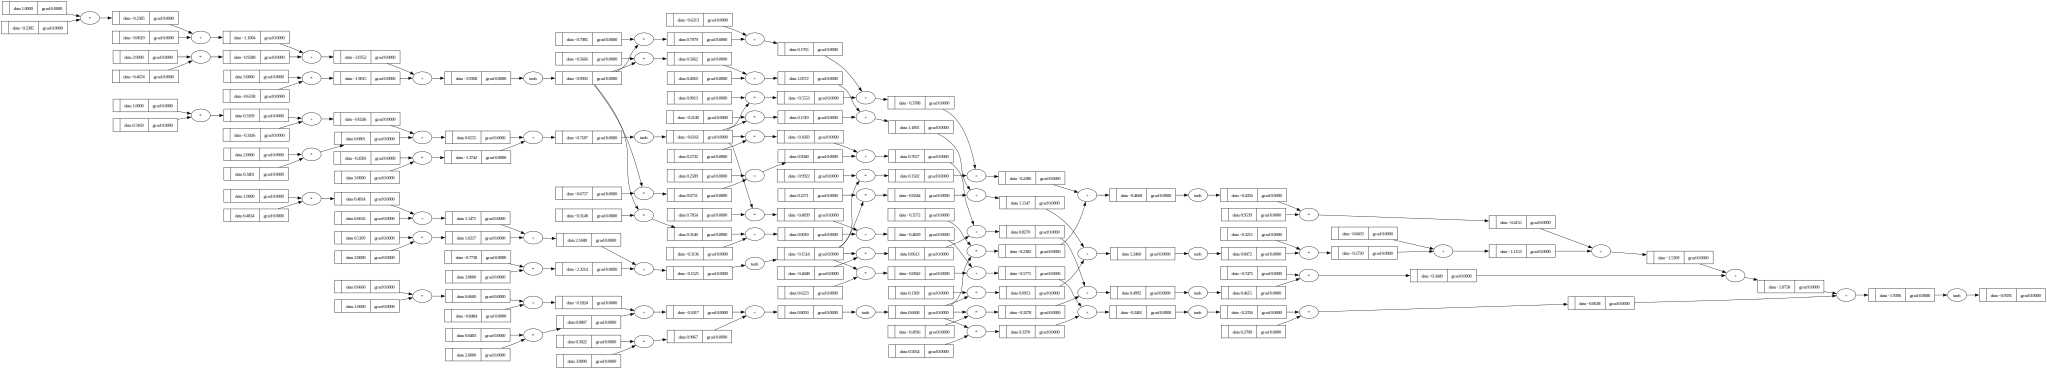

In [12]:
draw_dot(N(inp))

In [13]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [14]:
for k in range(20):
  
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backpropogation
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 6.039185305668772
1 6.039185305668772
2 6.039185305668772
3 6.039185305668772
4 6.039185305668772
5 6.039185305668772
6 6.039185305668772
7 6.039185305668772
8 6.039185305668772
9 6.039185305668772
10 6.039185305668772
11 6.039185305668772
12 6.039185305668772
13 6.039185305668772
14 6.039185305668772
15 6.039185305668772
16 6.039185305668772
17 6.039185305668772
18 6.039185305668772
19 6.039185305668772


In [15]:
ypred

[Value(data=0.5197467964118037, grad=-0.9605064071763927),
 Value(data=0.7178803282894285, grad=3.435760656578857),
 Value(data=0.6342717095635088, grad=3.2685434191270177),
 Value(data=0.5680447672401476, grad=-0.8639104655197047)]